In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.measure import ransac
from skimage.transform import ProjectiveTransform, AffineTransform
%matplotlib inline

## Loading Data

In [2]:
img_ref = cv2.imread('./frame000000.jpg')[:,:,::-1]
img_next = cv2.imread('./frame000020.jpg')[:,:,::-1]
depth_ref = cv2.imread('./reldepth000000.png')[:,:,::-1]
depth_next = cv2.imread('./reldepth000020.png')[:,:,::-1]

depth_abs_0 = cv2.imread("./absdepth000000.png")

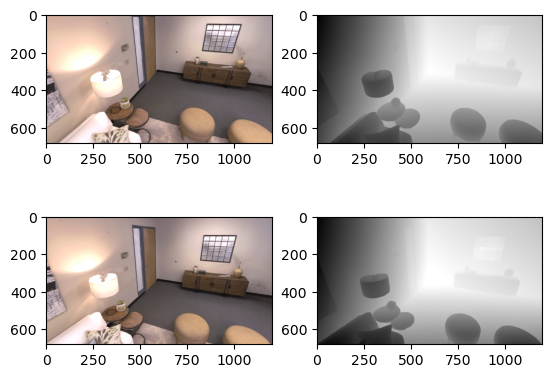

In [3]:
fig, ax = plt.subplots(nrows=2, ncols=2)

ax[0][0].imshow(img_ref)
ax[1][0].imshow(img_next)
ax[0][1].imshow(depth_ref)
ax[1][1].imshow(depth_next)

# plt.subplot(3,1,1)
# plt.imshow(img_ref)
# plt.subplot(3,1,2)
# plt.imshow(img_next)

# plt.subplot(3,2,1)
# plt.imshow(depth_ref)
# plt.subplot(3,2,2)
# plt.imshow(depth_next)

## Keypoint Detection

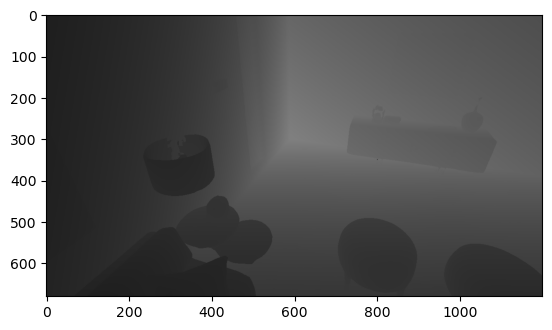

In [4]:
plt.imshow(depth_abs_0)

In [5]:
import torch

def get_pointcloud(color, depth, w2c, transform_pts=True, 
                   mask=None, compute_mean_sq_dist=False, mean_sq_dist_method="projective"):
    width, height = color.shape[2], color.shape[1]
    # CX = intrinsics[0][2]
    # CY = intrinsics[1][2]
    # FX = intrinsics[0][0]
    # FY = intrinsics[1][1]

    FX = 300
    FY = 300
    CX = 299.75
    CY = 169.75

    # Compute indices of pixels
    x_grid, y_grid = torch.meshgrid(torch.arange(width).cuda().float(), 
                                    torch.arange(height).cuda().float(),
                                    indexing='xy')
    xx = (x_grid - CX)/FX
    yy = (y_grid - CY)/FY
    xx = xx.reshape(-1)
    yy = yy.reshape(-1)
    depth_z = depth[0].reshape(-1)
    print(xx.device)
    print(yy.device)
    print(depth_z.device)
    print(width, height)
    # Initialize point cloud
    pts_cam = torch.stack((xx * depth_z, yy * depth_z, depth_z), dim=-1)
    if transform_pts:
        pix_ones = torch.ones(height * width, 1).cuda().float()
        pts4 = torch.cat((pts_cam, pix_ones), dim=1)
        c2w = torch.inverse(w2c)
        pts = (c2w @ pts4.T).T[:, :3]
    else:
        pts = pts_cam

    # Compute mean squared distance for initializing the scale of the Gaussians
    if compute_mean_sq_dist:
        if mean_sq_dist_method == "projective":
            # Projective Geometry (this is fast, farther -> larger radius)
            scale_gaussian = depth_z / ((FX + FY)/2)
            mean3_sq_dist = scale_gaussian**2
        else:
            raise ValueError(f"Unknown mean_sq_dist_method {mean_sq_dist_method}")
    
    # Colorize point cloud
    cols = torch.permute(color, (1, 2, 0)).reshape(-1, 3) # (C, H, W) -> (H, W, C) -> (H * W, C)
    point_cld = torch.cat((pts, cols), -1)

    # Select points based on mask
    if mask is not None:
        point_cld = point_cld[mask]
        if compute_mean_sq_dist:
            mean3_sq_dist = mean3_sq_dist[mask]

    if compute_mean_sq_dist:
        return point_cld, mean3_sq_dist
    else:
        return point_cld

In [6]:
w2c = torch.eye(4, device = "cuda")
depth = torch.tensor(depth_abs_0, device = "cuda").permute(2,0,1)
# print(img_ref.shape)
color = torch.from_numpy(img_ref.copy()).permute(2,0,1)
color = color.to("cuda")
# print(color.shape)
# print(color.device)
# print(depth.shape)

ptcld = get_pointcloud(color, depth, w2c)


cuda:0
cuda:0
cuda:0
1200 680


In [7]:
print(ptcld)
print(ptcld.shape)
ptcld_np = np.array(ptcld.cpu())

fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(ptcld_np[0:1000:10,0], ptcld_np[0:1000:10,1], ptcld_np[0:1000:10,2], c='r')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

tensor([[-29.9750, -16.9750,  30.0000, 206.0000, 172.0000, 160.0000],
        [-29.8750, -16.9750,  30.0000, 206.0000, 172.0000, 160.0000],
        [-29.7750, -16.9750,  30.0000, 205.0000, 171.0000, 159.0000],
        ...,
        [125.6150,  71.2950,  42.0000, 222.0000, 178.0000, 139.0000],
        [125.7550,  71.2950,  42.0000, 222.0000, 179.0000, 137.0000],
        [125.8950,  71.2950,  42.0000, 222.0000, 179.0000, 137.0000]],
       device='cuda:0')
torch.Size([816000, 6])


: 

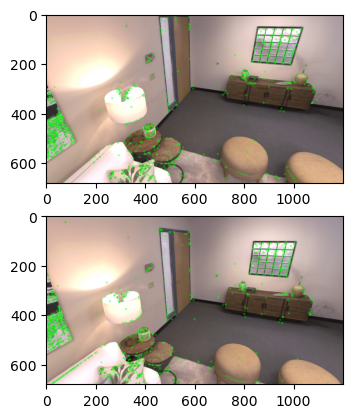

In [ ]:
# create orb detector
sift = cv2.SIFT_create()

kp1, des1 = sift.detectAndCompute(img_ref,None)
kp2, des2 = sift.detectAndCompute(img_next,None)

vis1 = cv2.drawKeypoints(img_ref, kp1, None, color=(0,255,0), flags=0)
vis2 = cv2.drawKeypoints(img_next, kp2, None, color=(0,255,0), flags=0)

plt.subplot(2,1,1)
plt.imshow(vis1)
plt.subplot(2,1,2)
plt.imshow(vis2)
plt.show()

# Keypoint Matching

In [ ]:
# FLANN_INDEX_KDTREE = 1
# index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
# search_params = dict(checks=50)

# flann = cv2.FlannBasedMatcher(index_params,search_params)
# matches = flann.knnMatch(des1,des2,k=2)

# # run BFMatcher
# # bf = cv2.BFMatcher()
# # matches = bf.knnMatch(des1,des2, k=2)


# good = []
# for m, n in matches:
#     if m.distance < 0.5*n.distance:
#         good.append(m)

# src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1, 2)
# dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1, 2)

# # Ransac
# model, inliers = ransac(
#         (src_pts, dst_pts),
#         AffineTransform, min_samples=4,
#         residual_threshold=8, max_trials=10000
#     )

# n_inliers = np.sum(inliers)

# inlier_keypoints_left = [cv2.KeyPoint(point[0], point[1], 1) for point in src_pts[inliers]]
# inlier_keypoints_right = [cv2.KeyPoint(point[0], point[1], 1) for point in dst_pts[inliers]]
# placeholder_matches = [cv2.DMatch(idx, idx, 1) for idx in range(n_inliers)]
# image3 = cv2.drawMatches(img_ref, inlier_keypoints_left, img_next, inlier_keypoints_right, placeholder_matches, None)

# src_pts = np.float32([ inlier_keypoints_left[m.queryIdx].pt for m in placeholder_matches ]).reshape(-1, 2)
# dst_pts = np.float32([ inlier_keypoints_right[m.trainIdx].pt for m in placeholder_matches ]).reshape(-1, 2)
    
# plt.figure(figsize=(30,30))
# plt.imshow(image3)

## Get Fundamental Matrix

In [ ]:
# '''
# dataset_name: 'replica'
# camera_params:
#   image_height: 680
#   image_width: 1200
#   fx: 600.0
#   fy: 600.0
#   cx: 599.5
#   cy: 339.5
#   png_depth_scale: 6553.5
#   crop_edge: 0
# '''
# # fx = 600.0
# # fy = 600.0
# # cx = 599.5
# # cy = 339.5
# fx = 300
# fy = 300
# cx = 299.75
# cy = 169.75

# K = np.array([[fx, 0, cx],
#               [0, fy, cy],
#               [0, 0, 1]])

# pts_l = []
# pts_r = []
# for i,(m,n) in enumerate(matches):
#     if m.distance < 0.5*n.distance:
#         pts_l.append(kp1[m.queryIdx].pt)
#         pts_r.append(kp2[m.trainIdx].pt)
        
# pts_l = np.array(pts_l)
# pts_r = np.array(pts_r)

# # pts_l_norm = cv2.undistortPoints(np.expand_dims(pts_l, axis=1), cameraMatrix=K, distCoeffs=None)
# # pts_r_norm = cv2.undistortPoints(np.expand_dims(pts_r, axis=1), cameraMatrix=K, distCoeffs=None)

# # E, mask = cv2.findEssentialMat(pts_l_norm, pts_r_norm, focal=1.0, pp=(0., 0.), method=cv2.RANSAC, prob=0.999, threshold=3.0)
# # points, R, t, mask = cv2.recoverPose(E, pts_l_norm, pts_r_norm)

# F = cv2.findFundamentalMat(pts_l, pts_r, cv2.FM_RANSAC, 0.1, 0.99)[0]
# E = np.dot(K.T, np.dot(F, K))
# points, R, t, mask = cv2.recoverPose(E, pts_l, pts_r)

# M_l = np.hstack((np.eye(3, 3), np.zeros((3, 1))))
# M_r = np.hstack((R, t))

# P_l = np.dot(K,  M_l)
# P_r = np.dot(K,  M_r)
# point_4d_hom = cv2.triangulatePoints(P_l, P_r, np.expand_dims(pts_l, axis=1), np.expand_dims(pts_r, axis=1))
# point_4d = point_4d_hom / np.tile(point_4d_hom[-1, :], (4, 1))
# point_3d = point_4d[:3, :].T

In [ ]:
# rotvec = cv2.Rodrigues(R)[0]
# print(rotvec)
# print(t)

# print()

# Rinv = np.linalg.inv(R)
# tinv = np.dot(-Rinv, t)
# rotvec = cv2.Rodrigues(Rinv)[0]
# print(rotvec)
# print(tinv)